In [3]:
from IPython.display import clear_output
!pip install anchor-exp
clear_output()

In [76]:
from __future__ import print_function
import numpy as np
import pandas as pd
np.random.seed(1)
import sys
import sklearn
import sklearn.ensemble
%reload_ext autoreload
%autoreload 2
from anchor import utils
from anchor import anchor_tabular
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

In [77]:
dataset_folder = 'datasets/'
dataset = utils.load_dataset('adult', balance=True, dataset_folder=dataset_folder, discretize=True)

In [78]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(dataset.train, dataset.labels_train)
print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, c.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, c.predict(dataset.test)))

Train 0.9350338780390594
Test 0.8489483747609943


In [79]:
print(dataset.categorical_names)
transformed_data = []
print(dataset.train)

for r in dataset.train:
    transformed_data.append([dataset.categorical_names[i][int(r_)] for i, r_ in enumerate(r)])        

print(transformed_data[0])

train_data = pd.DataFrame(transformed_data, columns=dataset.feature_names)


{1: ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 2: ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 3: ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 4: ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 5: ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 6: ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'], 7: ['Female', 'Male'], 8: ['0', '1', '2'], 9: ['0', '1', '2'], 11: ['?', 'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Repu

In [80]:
nb_vals = 250
y=[]
for k in range(0, len(dataset.train)):
    y.append(c.predict(dataset.train[k].reshape(1, -1))[0])

oh_enc = OneHotEncoder(handle_unknown='ignore', sparse=True)
X = oh_enc.fit_transform(train_data.iloc[0:nb_vals]).todok()
# !pip intall -U scikit-learn
feature_names = oh_enc.get_feature_names_out(train_data.columns)
#feature_names = col_names
t_X = X.transpose().toarray()
print(feature_names)

print(X.shape)

['Age_28.00 < Age <= 37.00' 'Age_37.00 < Age <= 48.00' 'Age_Age <= 28.00'
 'Age_Age > 48.00' 'Workclass_?' 'Workclass_Federal-gov'
 'Workclass_Local-gov' 'Workclass_Private' 'Workclass_Self-emp-inc'
 'Workclass_Self-emp-not-inc' 'Workclass_State-gov' 'Education_11th'
 'Education_12th' 'Education_5th-6th' 'Education_7th-8th' 'Education_9th'
 'Education_Assoc-acdm' 'Education_Assoc-voc' 'Education_Bachelors'
 'Education_Doctorate' 'Education_HS-grad' 'Education_Masters'
 'Education_Prof-school' 'Education_Some-college'
 'Marital Status_Divorced' 'Marital Status_Married-civ-spouse'
 'Marital Status_Married-spouse-absent' 'Marital Status_Never-married'
 'Marital Status_Separated' 'Marital Status_Widowed' 'Occupation_?'
 'Occupation_Adm-clerical' 'Occupation_Craft-repair'
 'Occupation_Exec-managerial' 'Occupation_Farming-fishing'
 'Occupation_Handlers-cleaners' 'Occupation_Machine-op-inspct'
 'Occupation_Other-service' 'Occupation_Priv-house-serv'
 'Occupation_Prof-specialty' 'Occupation_Pr

In [81]:
# Arg gen

instances_by_feature = {}

for i, col in enumerate(t_X):
    instances_by_feature.update({i: list(np.where(col)[0])})

#print(instances_by_feature)

# Coverage
covi_by_arg = dict()
covc_by_arg = dict()

def generate_args_lenN(n, ibyf, dataset, predictions, minimals=None):
    """
    Generates arguments of length n, given arguments of length 1.. n-1
    :param n: length of arguments to be generated
    :param ibyf: instances_by_feature
    :param predictions:
    :param minimals: arguments (minimal)
    :return:
    """

    def is_minimal(potential_arg, cl, minimals, n):
        # cl is class
        set_potential_arg = set(potential_arg)
        for k in range(n):
            for comb_ in combinations(potential_arg, k+1):
                if frozenset(comb_) in minimals[cl][k]:
                    return False
        return True

    if minimals is None:
        minimals = ([], [])
    assert len(minimals[0]) == n-1
    minimals[0].append(set())
    minimals[1].append(set())

    args = [set(), set()]
    potential_args_checked_count = 0
    for i, row in enumerate(dataset):
        for potential_arg in combinations(np.where(row)[0], n):
            cl = predictions[i]
            potential_args_checked_count += 1
            if not is_minimal(potential_arg, cl, minimals, n-1):
                continue
            selection = set.intersection(*[set(ibyf[w]) for w in potential_arg])  # all rows with all features of potential argument
            selection_preds = [predictions[i_] for i_ in selection]
            if selection_preds[:-1] == selection_preds[1:]:
                    args[selection_preds[0]].add(frozenset(potential_arg))
                    covi_by_arg.update({frozenset(potential_arg): selection}) #covi
                    minimals[cl][n-1].add(frozenset(potential_arg))
                    covc_by_arg.update({frozenset(potential_arg): set(selection_preds)}) #covc
    print(potential_args_checked_count, ' potential arg checked.')
    return args, minimals

  

def read_args(minimals, feature_names):
    arguments = [[], []]
    for cl in range(len(minimals)):
        for a in range(len(minimals[cl])):
            for f in minimals[cl][a]:
                arguments[cl].append(tuple([feature_names[k] for k in f]))
    return arguments

In [82]:
n = 0
minimals = None
print("len ", n, ":", minimals)
compute = True
if compute:
    while not minimals or len(minimals[0][-1]) != 0 or len(minimals[1][-1]) != 0:
        n += 1
        args, minimals = generate_args_lenN(n, instances_by_feature, X.toarray(), y, minimals)
        print("len ", n, ":", len(minimals[0]))

len  0 : None
3000  potential arg checked.
len  1 : 1
16500  potential arg checked.
len  2 : 2
55000  potential arg checked.
len  3 : 3
123750  potential arg checked.
len  4 : 4
198000  potential arg checked.
len  5 : 5
231000  potential arg checked.
len  6 : 6
198000  potential arg checked.
len  7 : 7


In [83]:
name_pre = 'adult_0-' + str(nb_vals) + '_'

if compute:
    ## Save
    pd.to_pickle(minimals, name_pre + 'minimals.df')
    ### Cov
    pd.to_pickle(covi_by_arg, name_pre + 'covibyarg.df')
    pd.to_pickle(covc_by_arg, name_pre + 'covcbyarg.df')
else: 
    ## Load
    minimals = pd.read_pickle('adult_0-100_minimals.df')
    covi_by_arg = pd.read_pickle(name_pre + 'covibyarg.df')
    covc_by_arg = pd.read_pickle(name_pre + 'covcbyarg.df')


In [84]:
from os import path
import networkx as nx
import pydot
import matplotlib.pyplot as plt

def consistent(arg1, arg2, col_p_features):
    for f1, f2 in zip(list(arg1), list(arg2)):
        if f1 != f2 and col_p_feature[f1] == col_p_feature[f2]:
            return False
    return True

def build_r_atk(minimals, col_p_feature, output_path=''):
    R_atk = []
    for cl in range(2):
        for l in range(len(minimals[cl])):
            for h1 in minimals[cl][l]:
                for l2 in range(l-1):
                    for h2 in minimals[1-cl][l2]:
                        if consistent(h1, h2, col_p_feature):
                            R_atk.append((h1, h2))

    pd.to_pickle(R_atk, path.join(output_path, 'R_atk_rt2_dev.df'))


def evaluate_r_atk(minimals, col_p_feature, input_path=''):
    build_r_atk(minimals, col_p_feature, input_path)
    R_atk = pd.read_pickle(path.join(input_path, 'R_atk_rt2_dev.df'))
    print('len', len(R_atk))

    G = nx.Graph()
    G.add_edges_from(R_atk)
    #G = nx.petersen_graph()
    nx.draw(G, with_labels=True, font_weight='bold')
    nx.drawing.nx_pydot.write_dot(G, "R_atk_fig.dot")
    plt.savefig("R_atk_fig.png")
    return G

{'Age': {0, 1, 2, 3}, 'Workclass': {4, 5, 6, 7, 8, 9, 10}, 'Education': {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}, 'Marital Status': {24, 25, 26, 27, 28, 29}, 'Occupation': {32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 30, 31}, 'Relationship': {44, 45, 46, 47, 48, 49}, 'Race': {50, 51, 52, 53, 54}, 'Sex': {56, 55}, 'Capital Gain': {57, 58, 59}, 'Capital Loss': {60, 61, 62}, 'Hours per week': {64, 65, 63}, 'Country': {66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83}}
{0: 'Age', 1: 'Age', 2: 'Age', 3: 'Age', 4: 'Workclass', 5: 'Workclass', 6: 'Workclass', 7: 'Workclass', 8: 'Workclass', 9: 'Workclass', 10: 'Workclass', 11: 'Education', 12: 'Education', 13: 'Education', 14: 'Education', 15: 'Education', 16: 'Education', 17: 'Education', 18: 'Education', 19: 'Education', 20: 'Education', 21: 'Education', 22: 'Education', 23: 'Education', 24: 'Marital Status', 25: 'Marital Status', 26: 'Marital Status', 27: 'Marital Status', 28: 'Marital Status', 29: 'Ma

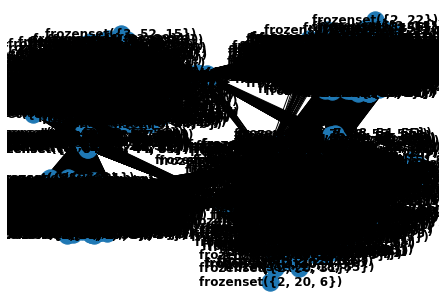

In [85]:
# Building Attack graph

features_p_col = {}
col_p_feature = {}

for col in train_data.columns:
    features_p_col[col] = set()
    for i, f in enumerate(feature_names):
        if col in f:
            features_p_col[col].add(i)
            col_p_feature[i] = col

print(features_p_col)
print(col_p_feature)

G = evaluate_r_atk(minimals, col_p_feature)

degs = np.array(list(G.degree()), dtype = [('node', 'object'), ('degree', int)])
degrees = np.sort(degs, order='degree')
print(degrees[-20:])

In [86]:
# Building Naive extensions
input_path=''
R_atk = pd.read_pickle(path.join(input_path, 'R_atk_rt2_dev.df'))

all_args = set()
for cl in range(len(minimals)):
    for l in range(len(minimals[cl])):
          all_args.update(minimals[cl][l])

print(len(all_args), ' args in total.')

# Finding naive extensions can also be done by finding all maximal independent 
# sets: nx.maximal_independent_set(G) can output one random one.

naive_extensions = {}
for (h1, h2) in R_atk:
    if h1 not in naive_extensions:
        naive_extensions[h1] = all_args.copy()
    if h2 not in naive_extensions:
        naive_extensions[h2] = all_args.copy()
    naive_extensions[h1].discard(h2)
    naive_extensions[h2].discard(h1)

print(len(naive_extensions))

print(set.intersection(*naive_extensions.values()))

1406  args in total.
1406
set()


In [87]:
covi_by_ext = dict()
covc_by_ext = dict()
max_covi = {}
max_covi_ext = {}

for ext in naive_extensions.values():
    covi = set.union(*[covi_by_arg[arg] for arg in ext])
    covi_by_ext.update({frozenset(ext): covi})
    if len(covi) > len(max_covi):
        max_covi_ext = ext
        max_covi = covi
    covc = set.union(*[covc_by_arg[arg] for arg in ext])
    covc_by_ext.update({frozenset(ext): covc})

print(len(covi_by_ext[frozenset(max_covi_ext)]), "/", len(X))

sorted_covs = [len(cov) for cov in covi_by_ext.values()]
sorted_covs.sort()
print(sorted_covs)

#for args in combinations(covi_by_ext.values(), 2):
#    assert(args not in R_atk)
#print("Coherence check")
print("Coherence not check")

print(max_covi_ext)
print(len(covi))

250 / 3000
[219, 219, 221, 222, 223, 224, 225, 227, 229, 230, 231, 232, 232, 232, 232, 232, 233, 234, 234, 235, 236, 237, 237, 237, 237, 237, 238, 238, 238, 238, 239, 239, 239, 239, 240, 240, 240, 241, 242, 242, 242, 242, 242, 242, 243, 243, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249

In [107]:
def explain(instance, i, extension=max_covi_ext, covi_by_ext=covi_by_ext):
    expl = set()
    covi = set()
    instance_set = set(np.where(instance.toarray() != 0)[1])
    if i in covi_by_ext[frozenset(extension)]:
        for arg in extension:
            if arg.issubset(instance_set):
                expl.add(arg)
                covi.update(covi_by_arg[arg])
    return expl, covi

def parse_features(explanation, feature_names=feature_names):
    parsed_expl = set()
    for arg in explanation:
        parsed_expl.add(frozenset([feature_names[k] for k in arg]))
    return parsed_expl

In [108]:
for arg in max_covi_ext:
    assert(arg in covi_by_arg.keys())
    assert(len(covi_by_arg[arg]) >= 1)

In [109]:
# Analysis
empty = 0
tot = 0
for k in range(X.shape[0]):
    expl, covi = explain(X.getrow(k), k, max_covi_ext, covi_by_ext)
    expl_parsed = parse_features(expl)
    print(k, len(covi), expl_parsed)
    if not expl:
        empty += 1
    tot += 1

print(empty, tot)

0 21 {frozenset({'Workclass_Self-emp-not-inc', 'Hours per week_40.00 < Hours per week <= 45.00'}), frozenset({'Age_Age > 48.00', 'Education_Some-college', 'Marital Status_Married-civ-spouse'}), frozenset({'Occupation_Sales', 'Relationship_Husband', 'Workclass_Self-emp-not-inc'}), frozenset({'Education_Some-college', 'Occupation_Sales', 'Country_United-States', 'Marital Status_Married-civ-spouse'}), frozenset({'Hours per week_40.00 < Hours per week <= 45.00', 'Age_Age > 48.00'}), frozenset({'Relationship_Husband', 'Education_Some-college', 'Age_Age > 48.00'}), frozenset({'Occupation_Sales', 'Hours per week_40.00 < Hours per week <= 45.00'}), frozenset({'Sex_Male', 'Education_Some-college', 'Age_Age > 48.00'}), frozenset({'Relationship_Husband', 'Occupation_Sales', 'Education_Some-college', 'Country_United-States'}), frozenset({'Occupation_Sales', 'Workclass_Self-emp-not-inc', 'Marital Status_Married-civ-spouse'}), frozenset({'Sex_Male', 'Occupation_Sales', 'Education_Some-college', 'Cou

78 7 {frozenset({'Sex_Male', 'Workclass_Private', 'Occupation_Protective-serv'}), frozenset({'Relationship_Not-in-family', 'Race_Black', 'Education_Bachelors', 'Capital Loss_0'}), frozenset({'Relationship_Not-in-family', 'Marital Status_Divorced', 'Race_Black'}), frozenset({'Race_Black', 'Education_Bachelors', 'Workclass_Private', 'Capital Loss_0'}), frozenset({'Hours per week_Hours per week > 45.00', 'Marital Status_Divorced', 'Education_Bachelors'}), frozenset({'Race_Black', 'Occupation_Protective-serv'}), frozenset({'Marital Status_Divorced', 'Race_Black', 'Age_28.00 < Age <= 37.00'}), frozenset({'Workclass_Private', 'Occupation_Protective-serv', 'Age_28.00 < Age <= 37.00'}), frozenset({'Education_Bachelors', 'Occupation_Protective-serv', 'Age_28.00 < Age <= 37.00'}), frozenset({'Hours per week_Hours per week > 45.00', 'Marital Status_Divorced', 'Workclass_Private'}), frozenset({'Race_Black', 'Education_Bachelors', 'Capital Loss_0', 'Age_28.00 < Age <= 37.00'}), frozenset({'Marital 

158 12 {frozenset({'Race_White', 'Sex_Female', 'Workclass_Local-gov', 'Age_Age > 48.00'}), frozenset({'Relationship_Wife', 'Education_HS-grad', 'Workclass_Local-gov'}), frozenset({'Relationship_Wife', 'Education_HS-grad', 'Race_White'}), frozenset({'Education_HS-grad', 'Workclass_Local-gov', 'Age_Age > 48.00'}), frozenset({'Relationship_Wife', 'Occupation_Adm-clerical', 'Age_Age > 48.00'}), frozenset({'Race_White', 'Age_Age > 48.00', 'Workclass_Local-gov', 'Country_United-States'}), frozenset({'Education_HS-grad', 'Occupation_Adm-clerical', 'Marital Status_Married-civ-spouse'}), frozenset({'Relationship_Wife', 'Race_White', 'Age_Age > 48.00'}), frozenset({'Occupation_Adm-clerical', 'Age_Age > 48.00', 'Marital Status_Married-civ-spouse'}), frozenset({'Occupation_Adm-clerical', 'Workclass_Local-gov'}), frozenset({'Race_White', 'Education_HS-grad', 'Sex_Female', 'Marital Status_Married-civ-spouse'}), frozenset({'Relationship_Wife', 'Education_HS-grad', 'Occupation_Adm-clerical'}), frozens

237 24 {frozenset({'Relationship_Unmarried', 'Age_37.00 < Age <= 48.00', 'Capital Loss_0'}), frozenset({'Education_HS-grad', 'Age_37.00 < Age <= 48.00', 'Occupation_Transport-moving'}), frozenset({'Relationship_Unmarried', 'Hours per week_Hours per week > 45.00', 'Age_37.00 < Age <= 48.00'}), frozenset({'Occupation_Transport-moving', 'Marital Status_Never-married'}), frozenset({'Relationship_Unmarried', 'Hours per week_Hours per week > 45.00', 'Marital Status_Never-married'}), frozenset({'Education_HS-grad', 'Occupation_Transport-moving', 'Country_United-States'}), frozenset({'Hours per week_Hours per week > 45.00', 'Age_37.00 < Age <= 48.00', 'Marital Status_Never-married', 'Workclass_Private'}), frozenset({'Education_HS-grad', 'Hours per week_Hours per week > 45.00', 'Occupation_Transport-moving'}), frozenset({'Relationship_Unmarried', 'Occupation_Transport-moving'}), frozenset({'Education_HS-grad', 'Marital Status_Never-married', 'Workclass_Private'}), frozenset({'Relationship_Unmar

In [90]:
explainer = anchor_tabular.AnchorTabularExplainer(
    dataset.class_names,
    dataset.feature_names,
    dataset.train,
    dataset.categorical_names)
#print(dataset.class_names, dataset.feature_names, dataset.categorical_names)

In [91]:
idx = 0
np.random.seed(1)
instance = dataset.train[idx].reshape(1, -1)[0]
print(instance)
print([dataset.categorical_names[i][int(r_)] for i, r_ in enumerate(instance)])

print('Prediction: ', explainer.class_names[c.predict(dataset.train[0].reshape(1, -1))[0]])
exp = explainer.explain_instance(dataset.train[idx], c.predict, threshold=0.95)

[ 3.  6. 15.  2. 12.  0.  4.  1.  2.  0.  1. 39.]
['Age > 48.00', 'Self-emp-not-inc', 'Some-college', 'Married-civ-spouse', 'Sales', 'Husband', 'White', 'Male', '2', '0', '40.00 < Hours per week <= 45.00', 'United-States']
Prediction:  b'>50K'


In [93]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())
# Get test examples where the anchora pplies
fit_anchor = np.where(np.all(dataset.train[:, exp.features()] == dataset.train[idx][exp.features()], axis=1))[0]
print('Anchor test precision: %.2f' % (np.mean(c.predict(dataset.test[fit_anchor]) == c.predict(dataset.test[idx].reshape(1, -1)))))
print('Anchor test coverage: %.2f' % (fit_anchor.shape[0] / float(dataset.test.shape[0])))

Anchor: Capital Gain = 2
Precision: 1.00
Coverage: 0.07


IndexError: index 1572 is out of bounds for axis 0 with size 1569

In [102]:
print(dataset.train.shape)
for i, x in enumerate(dataset.train):
    if y[i] == 0:
        if x[8] == 2:
            print(i, x, [dataset.categorical_names[i][int(r_)] for i, r_ in enumerate(x)])

(12545, 12)
1995 [ 3.  4. 15.  0.  1.  1.  4.  1.  2.  0.  0. 39.] ['Age > 48.00', 'Private', 'Some-college', 'Divorced', 'Adm-clerical', 'Not-in-family', 'White', 'Male', '2', '0', 'Hours per week <= 40.00', 'United-States']
3653 [ 0.  4. 13.  2.  5.  2.  4.  1.  2.  0.  0. 26.] ['Age <= 28.00', 'Private', 'Preschool', 'Married-civ-spouse', 'Farming-fishing', 'Other-relative', 'White', 'Male', '2', '0', 'Hours per week <= 40.00', 'Mexico']
5235 [ 0.  0.  0.  4.  0.  3.  4.  0.  2.  0.  0. 39.] ['Age <= 28.00', '?', '10th', 'Never-married', '?', 'Own-child', 'White', 'Female', '2', '0', 'Hours per week <= 40.00', 'United-States']
9622 [ 3.  6. 11.  2.  5.  5.  4.  0.  2.  0.  0. 39.] ['Age > 48.00', 'Self-emp-not-inc', 'HS-grad', 'Married-civ-spouse', 'Farming-fishing', 'Wife', 'White', 'Female', '2', '0', 'Hours per week <= 40.00', 'United-States']
10317 [ 3.  6.  9.  2. 10.  0.  4.  1.  2.  0.  2. 39.] ['Age > 48.00', 'Self-emp-not-inc', 'Bachelors', 'Married-civ-spouse', 'Prof-speci